## Partie modélisation

In [96]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [3]:
# Définir les tranches de BMI
# bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
# labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
bins = [0, 29.999, 100]  # Tranches de BMI
labels = ['Poids normal', 'Obésité']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

In [4]:
bins = [0, 35, 100]  # Tranches de BMI
labels = ['jeune', 'vieux']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["age_category"] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [5]:
del df["index"]
df.head()

,age,sex,bmi,children,smoker,region,charges,BMI_category,age_category
0,19,female,27.900,0,yes,southwest,16884.92400,Poids normal,jeune
1,18,male,33.770,1,no,southeast,1725.55230,Obésité,jeune
2,28,male,33.000,3,no,southeast,4449.46200,Obésité,jeune
3,33,male,22.705,0,no,northwest,21984.47061,Poids normal,jeune
4,32,male,28.880,0,no,northwest,3866.85520,Poids normal,jeune


In [6]:
features_of_interest = [
    "age",
    "sex",
    "children",
    "smoker",
    "region",
    "bmi",
    "BMI_category",
    "age_category"
]

numerical_column = [
    "children",
    "bmi",
    "age"
]


ordinal_column = [
    "sex",
    "smoker",
    "age_category",
    "BMI_category"
]

categorical_column = [
    "region",
]


target_name = "charges"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

### Training set

On prend un training set en faisant attention à la proportion de fumeur qui est importante :

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.85, random_state=42, stratify=data['smoker'])

### dummy model

In [8]:
dummy_model = DummyRegressor()
_ = dummy_model.fit(X_train,y_train)

In [9]:
target_predicted = dummy_model.predict(X_test)
target_predicted

array([13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
      

On obtient bien un modèle qui nous prédit pour tout le monde la moyenne des charges...

In [10]:
rmse = root_mean_squared_error(dummy_model.predict(X_test), y_test)
rmse

12054.89618229247

Avec un rmse de 12105 ce qui est beaucoup

### première regression linéaire

Les r2 pour nos valeurs numériques :

In [11]:
r_regression(numerical_data, target)

array([0.06738935, 0.19840083, 0.29830821])

In [12]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'age_category',
                                                   'BMI_category']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('linearregression', LinearRegression())])

In [13]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [14]:
cv_results = cross_validate(
    linear_model,
    data,
    target,
    cv=10,
    scoring={"r2": "r2", "rmse":rmse_scorer},
    return_train_score=True,
    return_estimator=True,
)

In [15]:
cv_results["test_r2"].mean()

np.float64(0.7495045219004149)

In [16]:
cv_results["test_rmse"].mean()

np.float64(-6004.03289441874)

On obtient en moyenne un rmse d'environ 6000 ce qui est toujours mieux que le dummy model mais pas tant...

### avec polynomiale features

In [17]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
linear_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'age_category',
                                                   'BMI_category']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [18]:
root_mean_squared_error(linear_model.predict(X_test), y_test)

3461.2053709540555

In [19]:
linear_model.score(X_test,y_test)

0.9173316949699921

On obtient un meilleur score. Etudions le poid de nos nouvelles features :

In [20]:
pd.set_option("display.max_columns", 100)
pd.DataFrame(data = [linear_model[-1].coef_ ], columns=linear_model[:2].get_feature_names_out())


,1,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,ordinal__sex,ordinal__smoker,ordinal__age_category,ordinal__BMI_category,numeric__children,numeric__bmi,numeric__age,categorical__region_northeast^2,categorical__region_northeast categorical__region_northwest,categorical__region_northeast categorical__region_southeast,categorical__region_northeast categorical__region_southwest,categorical__region_northeast ordinal__sex,categorical__region_northeast ordinal__smoker,categorical__region_northeast ordinal__age_category,categorical__region_northeast ordinal__BMI_category,categorical__region_northeast numeric__children,categorical__region_northeast numeric__bmi,categorical__region_northeast numeric__age,categorical__region_northwest^2,categorical__region_northwest categorical__region_southeast,categorical__region_northwest categorical__region_southwest,categorical__region_northwest ordinal__sex,categorical__region_northwest ordinal__smoker,categorical__region_northwest ordinal__age_category,categorical__region_northwest ordinal__BMI_category,categorical__region_northwest numeric__children,categorical__region_northwest numeric__bmi,categorical__region_northwest numeric__age,categorical__region_southeast^2,categorical__region_southeast categorical__region_southwest,categorical__region_southeast ordinal__sex,categorical__region_southeast ordinal__smoker,categorical__region_southeast ordinal__age_category,categorical__region_southeast ordinal__BMI_category,categorical__region_southeast numeric__children,categorical__region_southeast numeric__bmi,categorical__region_southeast numeric__age,categorical__region_southwest^2,categorical__region_southwest ordinal__sex,categorical__region_southwest ordinal__smoker,categorical__region_southwest ordinal__age_category,categorical__region_southwest ordinal__BMI_category,categorical__region_southwest numeric__children,categorical__region_southwest numeric__bmi,categorical__region_southwest numeric__age,ordinal__sex^2,ordinal__sex ordinal__smoker,ordinal__sex ordinal__age_category,ordinal__sex ordinal__BMI_category,ordinal__sex numeric__children,ordinal__sex numeric__bmi,ordinal__sex numeric__age,ordinal__smoker^2,ordinal__smoker ordinal__age_category,ordinal__smoker ordinal__BMI_category,ordinal__smoker numeric__children,ordinal__smoker numeric__bmi,ordinal__smoker numeric__age,ordinal__age_category^2,ordinal__age_category ordinal__BMI_category,ordinal__age_category numeric__children,ordinal__age_category numeric__bmi,ordinal__age_category numeric__age,ordinal__BMI_category^2,ordinal__BMI_category numeric__children,ordinal__BMI_category numeric__bmi,ordinal__BMI_category numeric__age,numeric__children^2,numeric__children numeric__bmi,numeric__children numeric__age,numeric__bmi^2,numeric__bmi numeric__age,numeric__age^2
0,-4.363251e-13,291.328382,363.108921,17.719401,-672.156704,-503.936217,13797.561452,-513.164619,-271.782448,1604.392523,-326.722647,3911.724747,291.328382,-4.547474e-12,4.547474e-13,3.325340e-12,-501.395367,2923.248736,-275.279383,1160.038245,739.906978,1291.209598,412.067692,363.108921,-3.183231e-12,-1.818989e-12,333.671073,4038.887745,-1450.334019,-471.155383,972.779495,-450.740664,1706.157803,17.719401,2.273737e-13,-209.552841,3400.332948,1250.286147,-1963.895407,-57.90327,-1532.544942,736.115617,-672.156704,-126.659082,3435.092021,-37.837363,1003.230098,-50.39068,365.353362,1057.383636,-503.936217,-528.398152,508.634642,611.700891,-104.48274,525.59633,-221.659359,13797.561452,-348.525998,-14540.298059,-485.256982,4663.214433,-201.57498,-513.164619,643.217531,-408.399349,838.886024,4542.813748,-271.782448,434.020565,-278.890723,-182.66536,-418.567224,234.589821,375.078616,-183.534955,-543.554561,7.716638


In [21]:
weights = linear_model[-1].coef_ 
null_features_weight = [w for w in weights if abs(w) < 0.001]
len(null_features_weight)

7

On a 7 des features dont on peut se débarasser. Utilisons maintenant Lasso.

### avec lasso

In [22]:
lasso_model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(1))
lasso_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'age_category',
                                                   'BMI_category']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1))])

In [23]:
lasso_model.score(X_test,y_test)

0.9176337865490234

In [24]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3454.8755086834676

Pas de gain significatif. Faison une étude Pour trouver les meilleurs hyper paramètres : 

### Hyperparamètre tuning Lasso

In [25]:
lasso_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("lasso", Lasso())
])

param_grid = {
    "poly__degree": [2, 3], 
    "lasso__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+08, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.369e+08, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarn

{'lasso__alpha': np.float64(1.0), 'poly__degree': 2}

In [26]:
grid_search.best_score_

np.float64(0.8509596372973529)

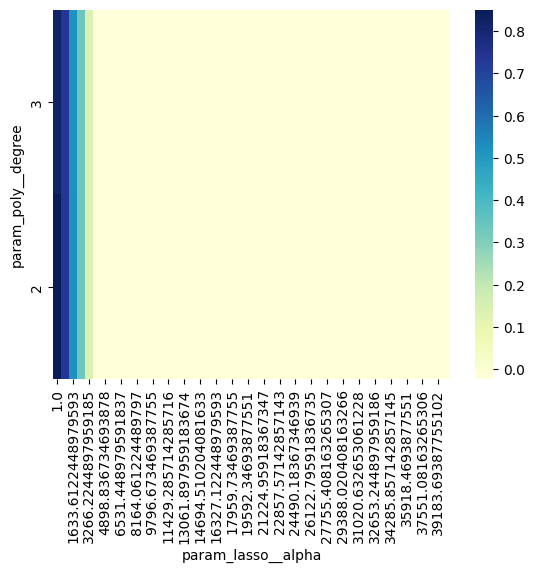

In [27]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__degree"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

on peut abandoner le degre 3 et on va se concentrer sur des valeurs de alpha entre 0 et 100...

In [28]:
param_grid = {
    "lasso__alpha": np.linspace(0, 100, 1001), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

best_param_alpha = grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.241e+09, tolerance: 1.315e+07 Linear regression models wit

In [29]:
print(best_param_alpha , grid_search.best_score_)

{'lasso__alpha': np.float64(33.4)} 0.8552886961017766


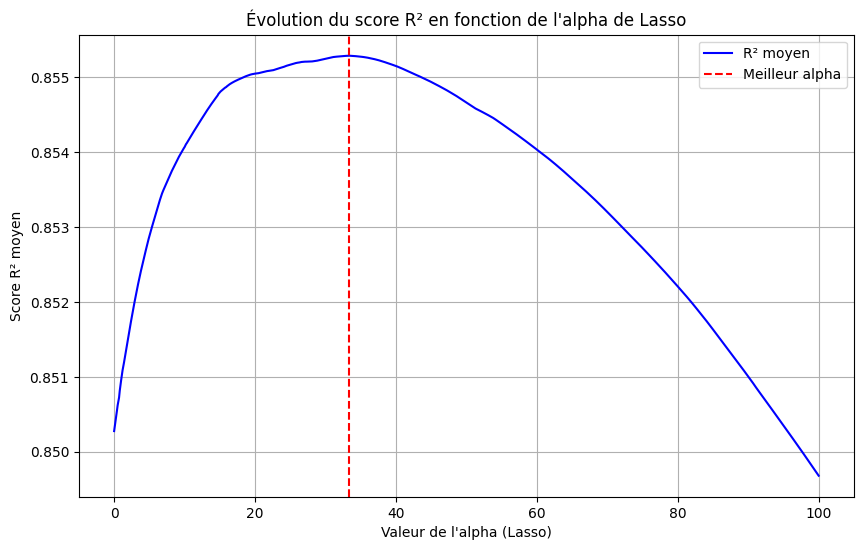

In [30]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

Le meilleur alpha semble être 45. Essayons tout de même entre 0 et 1 :

In [31]:
param_grid = {
    "lasso__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.241e+09, tolerance: 1.315e+07 Linear regression models wit

{'lasso__alpha': np.float64(1.0)}

In [32]:
grid_search.best_score_

np.float64(0.8509596372973529)

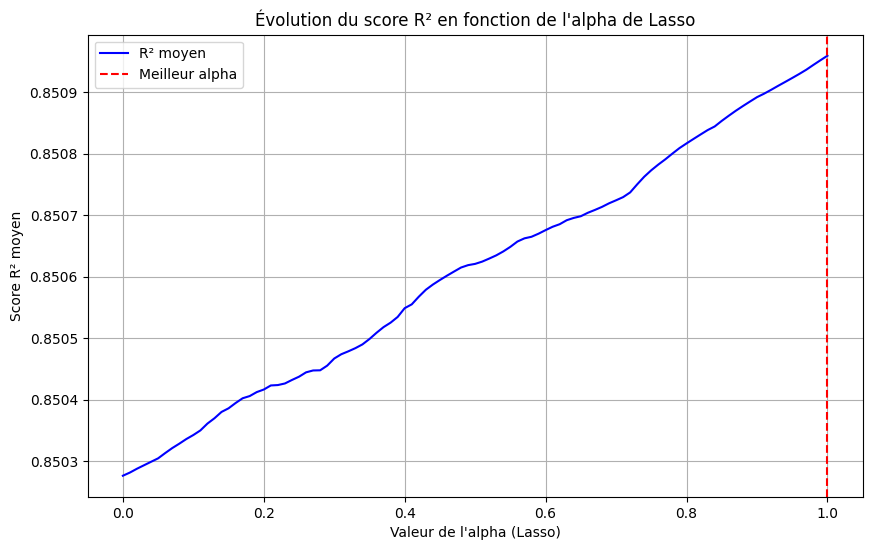

In [33]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

45 et meilleur. Etudions maintenant les carrés du polynôme avec un alpha pour alpha entre 35 et 55 :

In [34]:
param_grid = {
    "poly__interaction_only": [True, False], 
    "lasso__alpha": np.linspace(35, 55, 21), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lasso__alpha': np.float64(35.0), 'poly__interaction_only': False}

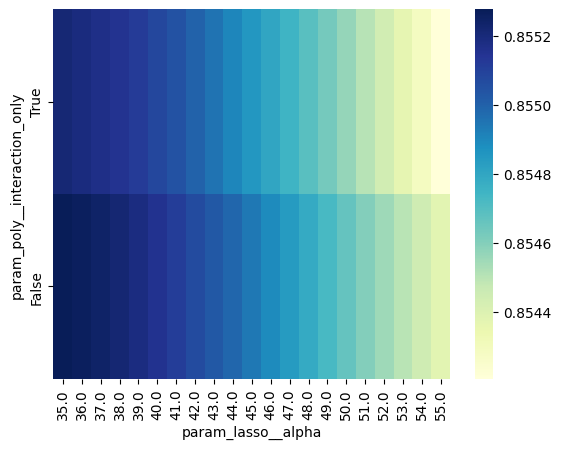

In [35]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__interaction_only"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

On a de meilleurs résultats en conservant les carrés...

In [36]:
best_param_alpha['lasso__alpha']

np.float64(33.4)

In [37]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'])
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'age_category',
                                                   'BMI_category']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('poly', PolynomialFeatures()),
                ('lasso', Lasso(alpha=np.float64(33.4)))])

In [38]:
lasso_model.score(X_test,y_test)

0.9237711558397398

L'amélioration est tout de même peu significative...

In [39]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3323.667111714121

### Elastic net

In [40]:
elastic_net_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("elastic", ElasticNet())
])
elastic_net_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'age_category',
                                                   'BMI_category']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('poly', PolynomialFeatures()), ('elastic', ElasticNet())])

In [41]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [42]:
elastic_net_model.score(X_test,y_test)

0.6654795010900103

In [43]:
root_mean_squared_error(elastic_net_model.predict(X_test), y_test)

6962.564320686344

In [44]:
param_grid = {
    "elastic__l1_ratio": np.linspace(0, 1, 20), 
    "elastic__alpha": np.linspace(1, 100, 20)
}

grid_search = GridSearchCV(
    elastic_net_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.742e+10, tolerance: 1.315e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.764e+10, tolerance: 1.298e+07 Linear regression models wit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'age_category',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('elastic', ElasticNet())]),
             par...
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ]),
                         'elastic__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='r2')

In [45]:
print(grid_search.best_params_, grid_search.best_score_)

{'elastic__alpha': np.float64(32.26315789473684), 'elastic__l1_ratio': np.float64(1.0)} 0.8552823527943417


In [46]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

In [47]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [48]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_elastic__l1_ratio"],
    columns=["param_elastic__alpha"],
    )

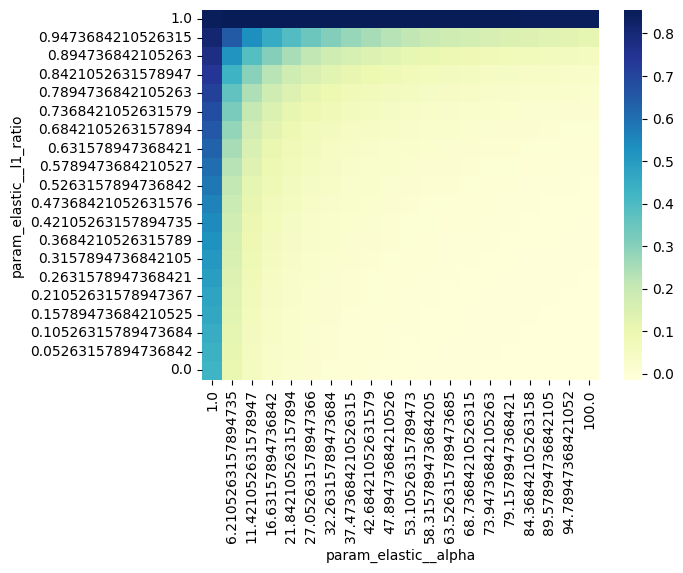

In [49]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

In [50]:
param_grid = {
    "elastic__l1_ratio": np.linspace(0.9, 1, 20), 
    "elastic__alpha": np.linspace(50, 150, 100)
}

grid_search = GridSearchCV(
    elastic_net_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [94]:
print(grid_search.best_params_, grid_search.best_score_)

{'elastic__alpha': np.float64(50.0), 'elastic__l1_ratio': np.float64(1.0)} 0.8532800713811541


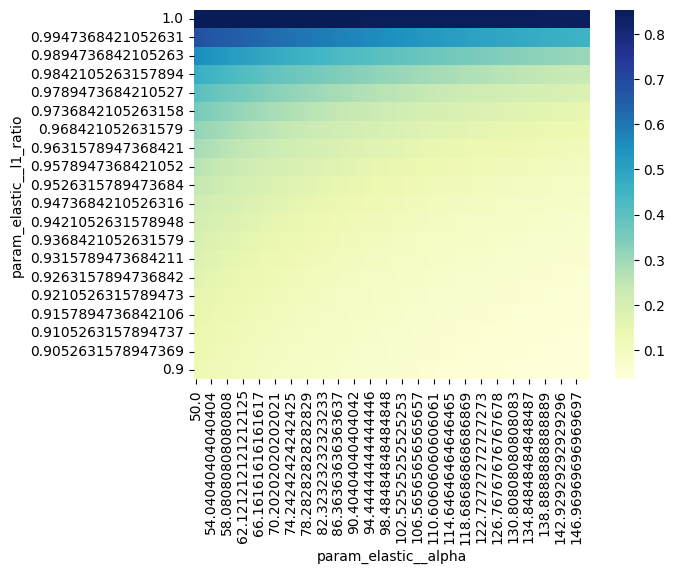

In [95]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_elastic__l1_ratio"],
    columns=["param_elastic__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()


## Analyse des résultats

On va d'abord récuperer nos données transformé.

In [51]:
data_transform = pd.DataFrame(data = lasso_model[:2].fit_transform(X_train), columns=lasso_model[:2].get_feature_names_out())

In [52]:
X = data_transform
Y = y_train.reset_index()

Je créer une data frame avec nos index pour receuillir les résultats

In [53]:
analyses = pd.DataFrame(Y["index"])
analyses

,index
0,1094
1,94
2,349
3,410
4,981
...,...
1131,674
1132,752
1133,319
1134,934


In [54]:
n,p = X.shape
print(n,p)

1136 78


Ensuite on implémente la régression linéaire avec statsmodels :

In [55]:
import statsmodels.api as sm
X = sm.add_constant(X) # J'ajoute une colonne de 1 qui va corespondre à l'intercept 
reg_multi = sm.OLS(Y.drop("index", axis=1),X) 
reg_multi = reg_multi.fit()


In [56]:
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     126.1
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:24:11   Log-Likelihood:                -11154.
No. Observations:                1136   AIC:                         2.242e+04
Df Residuals:                    1080   BIC:                         2.270e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
1                                                            5743.7838    738.480      7.778      0.000    4294.766    7192.802
categorical__region_northeast                                1727.2743    404.103      4.274      0.000     934.358    2520.191
categorical__region_northwest                                1799.0549    407.637      4.413      0.000     999.204    2598.906
categorical__region_southeast                                1453.6653    459.264      3.165      0.002     552.515    2354.816
categorical__region_southwest                                 763.7892    433.847      1.761      0.079     -87.490    1615.069
ordinal__sex                                                 -503.9362    366.044     -1.377      0.169   -1222.175     214.302
ordinal__smoker                                               1.38e+04    483.869     28.515      0.000    1.28e+04    1.47e+04
ordinal__age_category                                        -513.1646    595.975     -0.861      0.389   -1682.566     656.236
ordinal__BMI_category                                        -271.7824    585.483     -0.464      0.643   -1420.596     877.031
numeric__children                                            1604.3925    603.003      2.661      0.008     421.203    2787.582
numeric__bmi                                                 -326.7226   1004.337     -0.325      0.745   -2297.395    1643.950
numeric__age                                                 3911.7247   1827.459      2.141      0.033     325.953    7497.497
categorical__region_northeast^2                              1727.2743    404.103      4.274      0.000     934.358    2520.191
categorical__region_northeast categorical__region_northwest  4.265e-12   3.73e-12      1.143      0.253   -3.06e-12    1.16e-11
categorical__region_northeast categorical__region_southeast  2.773e-12   2.75e-12      1.007      0.314   -2.63e-12    8.18e-12
categorical__region_northeast categorical__region_southwest  3.018e-12   2.13e-12      1.418      0.156   -1.16e-12    7.19e-12
categorical__region_northeast ordinal__sex                   -501.3954    494.224     -1.015      0.311   -1471.143     468.352
categorical__region_northeast ordinal__smoker                2923.2487    632.304      4.623      0.000    1682.565    4163.933
categorical__region_northeast ordinal__age_category          -275.2794    986.789     -0.279      0.780   -2211.521    1660.962
categorical__region_northeast ordinal__BMI_category          1160.0382    847.330      1.369      0.171    -502.561    2822.637
categorical__region_northeast numeric__children               739.9070    439.832      1.682      0.093    -123.115    1602.929
categorical

### Etude d'atypicité

#### Sur les variable explicative

leviers des observations de Bersley : On peut calculer les leviers : $$h_{ii}=X_{i}^T(X^YX)^{-1}X_i$$ Si cette valeur est supérieur au seuil des leviers ($2∗\frac{p}{n}$) on peut considérer l'observation comme atypique.

In [57]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print(seuil_levier)

0.13732394366197184


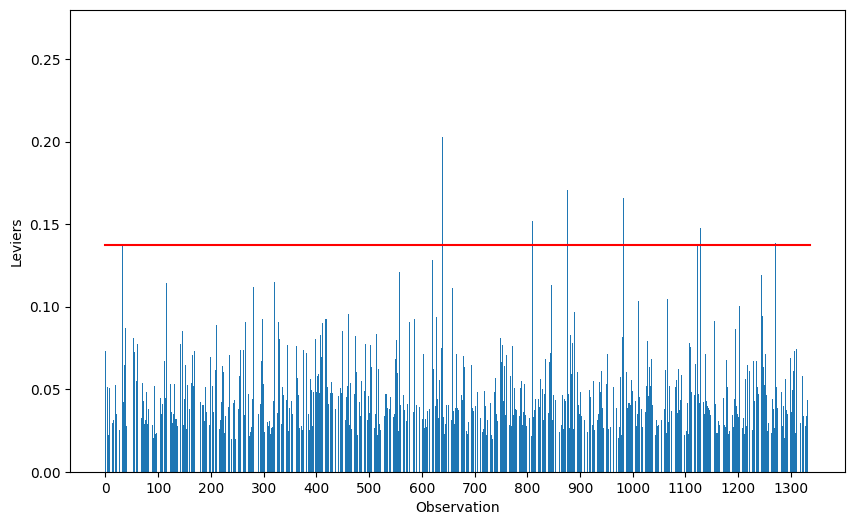

In [58]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['levier'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_levier, seuil_levier], color='r')
plt.show()

In [59]:
len(analyses.loc[analyses['levier'] > seuil_levier, :])

15

Nous n'avons que 16 valeurs atypiques sans considérer la target

#### Sur la variable à expliquer

In [60]:
alpha = 0.05

On calculs les résidus studentisés internes avec scipy et on fixe un alpha à 0.05 pour avoir une confiance de 95%

In [61]:
from scipy.stats import t
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

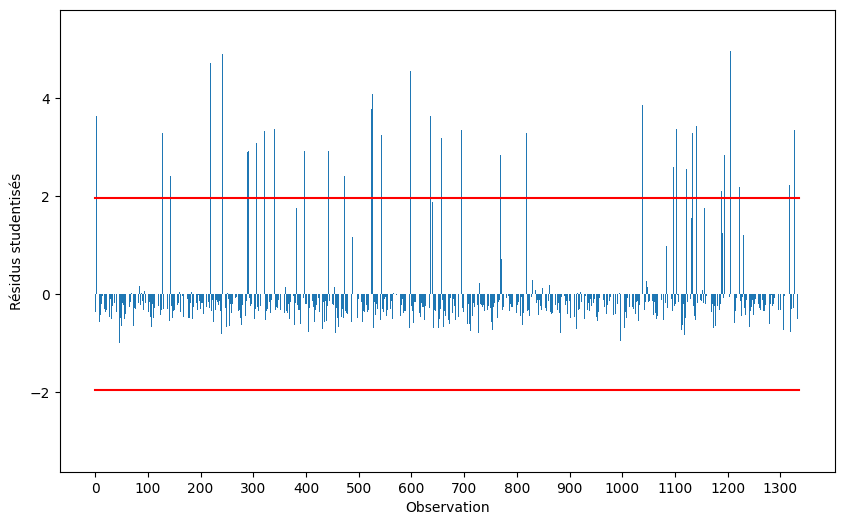

In [62]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['rstudent'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1336], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1336], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [63]:
len(analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier),:])

97

In [64]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")

On a 95 valeurs atypiques en tout.

### Etude de l'influence :

On calcul pour charque observation la distance de COOK $D_i$ et on la considère influente si $$D_i > \dfrac{4}{n-p}$$

In [65]:
influence = reg_multi.get_influence().summary_frame()

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [66]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

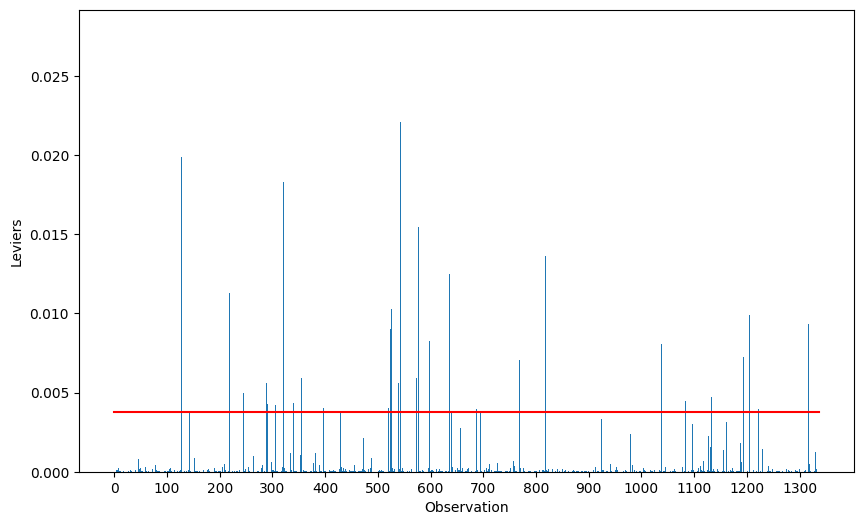

In [67]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['dcooks'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [68]:
len(analyses.loc[analyses['dcooks'] > seuil_dcook, :])

67

On a 60 valeurs influentes. 

In [69]:
len(analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:])

66

Et 59 de ces valeurs sont atypiques.

### Tentative en enlevant les valeurs influentes et atypiques :

In [70]:
obesrvations_to_drop = analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:]

In [71]:
X_train

,age,sex,children,smoker,region,bmi,BMI_category,age_category
1094,18,female,4,no,northeast,31.350,Obésité,jeune
94,64,female,2,yes,southwest,31.300,Obésité,vieux
349,19,male,0,no,northwest,27.835,Poids normal,jeune
410,19,male,0,no,northwest,17.480,Poids normal,jeune
981,31,male,3,yes,southwest,25.900,Poids normal,jeune
...,...,...,...,...,...,...,...,...
674,45,male,0,no,northwest,21.375,Poids normal,vieux
752,58,female,0,no,southeast,22.770,Poids normal,vieux
319,32,male,1,no,northeast,37.335,Obésité,jeune
934,59,female,0,no,southwest,27.500,Poids normal,vieux


In [72]:
X2_train = X_train
y2_train = y_train
for index in obesrvations_to_drop["index"]:
    X2_train = X2_train.drop(index)
    y2_train = y2_train.drop(index)

In [73]:
lasso_model.fit(X_train,y_train)
lasso_model.score(X_test,y_test)

0.9237711558397398

In [74]:
lasso_model.fit(X2_train,y2_train)
lasso_model.score(X_test,y_test)

0.9297620207776265

On a un meilleur modèle !

In [75]:
param_grid = {
    "lasso__alpha": np.linspace(0, 100, 1001), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

best_param_alpha = grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e+09, tolerance: 7.242e+06 Linear regression models wit

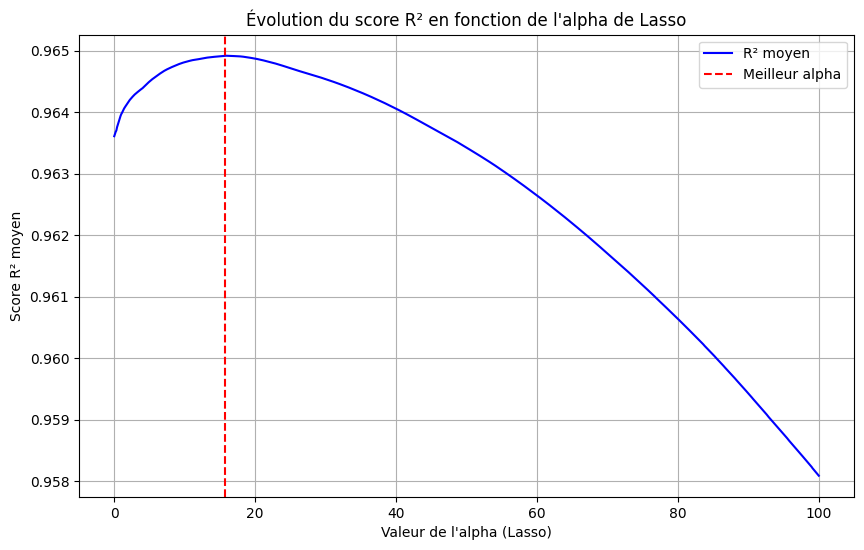

In [76]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
best_param_alpha

{'lasso__alpha': np.float64(15.700000000000001)}

In [107]:
best_score = [0,0]

for i in range(0,100):
    lasso_model.set_params(poly__degree=2, lasso__alpha = i)
    best_lasso_model = lasso_model.fit(X2_train,y2_train)
    if best_score[1] < best_lasso_model.score(X_test,y_test) :
        best_score = [i, best_lasso_model.score(X_test,y_test) ]


/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e+09, tolerance: 1.430e+07 Linear regression models wit

In [108]:
best_score

[50, 0.930159219499577]

In [109]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'])
best_lasso_model = lasso_model.fit(X2_train,y2_train)

In [110]:
best_lasso_model.score(X_test,y_test)

0.9288167213627788

### Etude de la colinéarité

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = reg_multi.model.exog
v = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [83]:
v = [item for item in v if item >10]
v

[np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(13.727217745887891),
 np.float64(inf),
 np.float64(10.10338325652579),
 np.float64(inf),
 np.float64(35.9275665837266),
 np.float64(29.666093043498112),
 np.float64(69.66478655118313),
 np.float64

Pas de colinéarité...

In [84]:
import pickle

with open('best_lasso_model.pkl', 'wb') as f:
    pickle.dump(best_lasso_model, f)

### Ridge

In [85]:
ridge_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("ridge", Ridge())
])

In [86]:
param_grid = {
    "ridge__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'age_category',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid...
       1.95923469e+04, 2.04086531e+04, 2.12249592e+04, 2.20412653e+04,
       2.28575714e+04, 2.36738776e+04, 2.44901837e+04, 2.53064898e+04,
       2.61227959e+04, 2.69391020e+04, 2.77554082e+04, 2.85717143e+04,
       2.93880204e+04, 3.02043265e+04, 3.10206327e+04, 3.18369388e+04,
       3.26532449e+04, 3.34695510e+04, 3.42858571e+04, 3.51021633e+04,
       3.59184694e+04, 3.67347755e+04, 3.75510816e+04, 3.83673878e+04,
       3.91836939e+04, 4.00000000e+04])},
             scoring='r2')

In [87]:
grid_search.best_params_

{'ridge__alpha': np.float64(1.0)}

In [88]:
param_grid = {
    "ridge__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'age_category',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['children',
                                                                          'bmi',
                                                                          'age'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid...
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])},
             scoring='r2')

In [89]:
grid_search.best_params_

{'ridge__alpha': np.float64(0.07)}

In [90]:
param_grid = {
    "ridge__alpha": np.linspace(0, 0.001, 101), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)
grid_search.best_params_

{'ridge__alpha': np.float64(0.001)}

In [91]:
best_param_r_alpha = grid_search.best_params_

In [92]:
grid_search.best_score_

np.float64(0.9636095136913672)

In [93]:
ridge_model.set_params(ridge__alpha = best_param_r_alpha['ridge__alpha'])
best_ridge_model = ridge_model.fit(X2_train,y2_train)

In [94]:
best_ridge_model.score(X_test,y_test)

0.926822221249693

## Lasso with target regression

In [105]:
lasso_model.fit(X2_train, np.log(y2_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'age_category',
                                                   'BMI_category']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('poly', PolynomialFeatures()),
                ('lasso', Lasso(alpha=np.float64(15.700000000000001)))])

In [98]:
lasso_model_targettransformed = TransformedTargetRegressor(regressor=lasso_model,func=np.log,inverse_func=np.exp)

In [101]:
lasso_model_targettransformed.fit(X2_train,y2_train)

NameError: name 'func' is not defined

In [106]:
lasso_model_targettransformed.score(X_test,np.log(y_test))

-83743267.06256387

In [103]:
lasso_model_targettransformed.score(X_test,y_test)

-0.12627408846534904